In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import yfinance as yf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Flatten,SimpleRNN,Lambda,LSTM

In [36]:
df_acer = yf.Ticker("2353.TW")
df_acer = df_acer.history(period="max",interval="1d",)

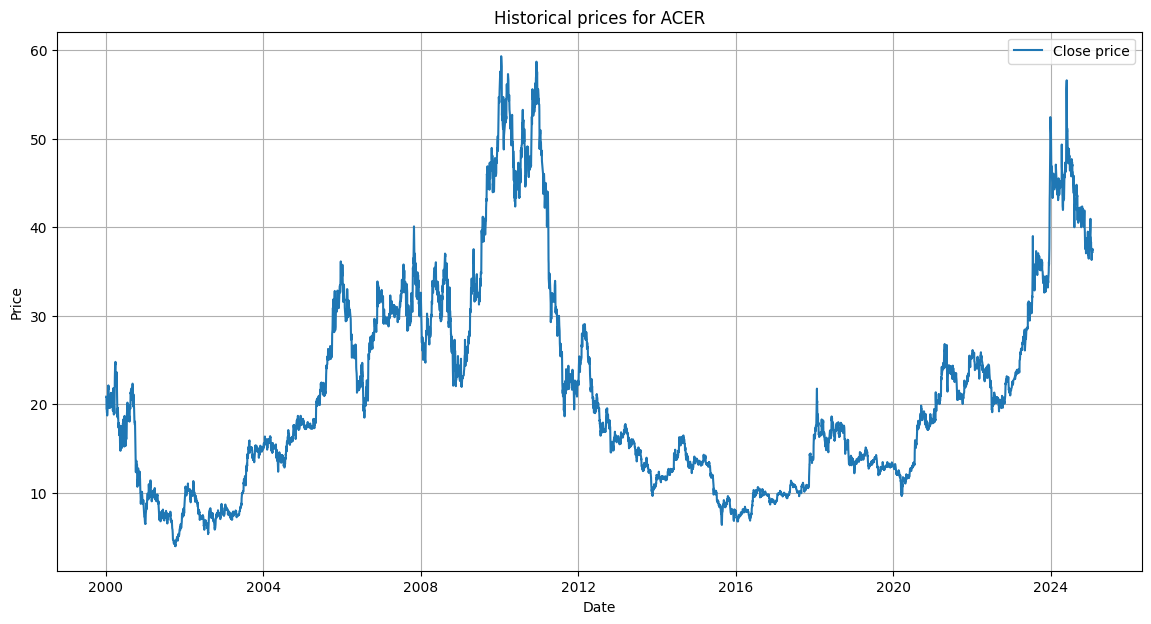

In [37]:
#畫圖
plt.figure(figsize=(14,7))
plt.plot(df_acer.index, df_acer['Close'],
label='Close price')
plt.title('Historical prices for ACER')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
#數據處理
data = df_acer['Close'].values
#參數設定
window_size = 20
#xy設定
X, y = [], []
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
    y.append(data[i])
X = np.array(X)
y = np.array(y)

In [39]:
#分割訓練測試集
split = int(len(data)*0.8)
X_train , X_val = X[:split] , X[split:]
y_train , y_val = y[:split] , y[split:]

In [6]:
# data處理
batch_size = 128
buffer_size = 10000
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [33]:
#模型驗證&畫圖函式
def evaluated(model,X_val,y_val):
    forecast_val = model.predict(X_val)
    forecast_val = np.squeeze(forecast_val)#處理形狀，改成(727,)
    print(f'y_val:{y_val.shape}')
    print(f'forecast_val:{forecast_val.shape}')
    mae_exp = mean_absolute_error(y_val, forecast_val)
    mse_exp = mean_squared_error(y_val, forecast_val)
    mape_exp = mean_absolute_percentage_error(y_val, forecast_val)
    return mae_exp, mse_exp, mape_exp, forecast_val


def plot_predict(forecast_val,y_val,title = 'Ann model plot',labels='Exponential Decay Predicted',start_date=None, end_date=None):
    plt.plot(forecast_val,label=labels)
    plt.plot(y_val, label='Actual')
    if start_date and end_date:
        start_idx = df_acer.index.get_loc(pd.Timestamp(start_date))
        end_idx = df_acer.index.get_loc(pd.Timestamp(end_date))
        start_idx -= len(data) - len(y_val)
        end_idx -= len(data) - len(y_val)
        plt.xlim(start_idx, end_idx)
    plt.title(title)
    plt.legend()
    plt.show()

In [8]:
##建立模型
#ANN
ann_model = Sequential()
ann_model.add(Dense(128,activation='relu',input_shape=(window_size,)))
ann_model.add(Dense(64,activation='relu'))
ann_model.add(Dense(64,activation='relu'))
ann_model.add(Dense(32,activation='relu'))
ann_model.add(Dense(1))
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [9]:
#訓練
ann_model.compile(loss='mse', optimizer='adam')
ann_model.fit(train_data, epochs=150)

Epoch 1/150
40/40 [==============================] - 1s 3ms/step - loss: 29.1222
Epoch 2/150
40/40 [==============================] - 0s 2ms/step - loss: 2.5474
Epoch 3/150
40/40 [==============================] - 0s 2ms/step - loss: 1.9758
Epoch 4/150
40/40 [==============================] - 0s 2ms/step - loss: 1.6703
Epoch 5/150
40/40 [==============================] - 0s 2ms/step - loss: 1.1780
Epoch 6/150
40/40 [==============================] - 0s 2ms/step - loss: 1.0289
Epoch 7/150
40/40 [==============================] - 0s 2ms/step - loss: 0.8887
Epoch 8/150
40/40 [==============================] - 0s 3ms/step - loss: 0.8199
Epoch 9/150
40/40 [==============================] - 0s 3ms/step - loss: 4.5932
Epoch 10/150
40/40 [==============================] - 0s 2ms/step - loss: 1.0582
Epoch 11/150
40/40 [==============================] - 0s 2ms/step - loss: 1.2341
Epoch 12/150
40/40 [==============================] - 0s 2ms/step - loss: 0.8219
Epoch 13/150
40/40 [================

39/39 [==============================] - 0s 1ms/step
MAE:0.42682942748069763,MSE:0.47435539960861206,MAPE:1.5294735431671143


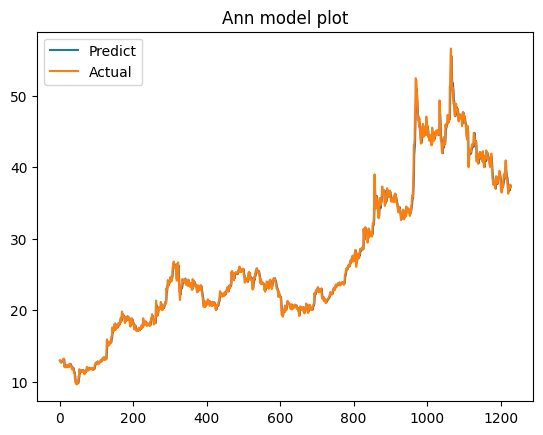

In [11]:
#評估
mae_exp, mse_exp, mape_exp, forecast_val = evaluated(ann_model,X_val,y_val)
print(f"MAE:{mae_exp},MSE:{mse_exp},MAPE:{mape_exp}")
plot_predict(forecast_val,y_val,labels='Predict')

In [12]:
#儲存模型
ann_model.save('ANN_time_forecast_model')

INFO:tensorflow:Assets written to: ANN_time_forecast_model\assets


In [60]:
##評估ann_model模型預測趨勢準確率
#導入模型
ann_model = tf.keras.models.load_model('ANN_time_forecast_model')

In [61]:
#抓取近1年數據
df_acer = yf.Ticker("2353.TW")
df_acer = df_acer.history(period="1y",interval="1d",)
data_1year = df_acer['Close'].values
data_1year = np.array(data_1year)
test_sample = data_1year[:20]
test_sample = test_sample.reshape((1, 20, 1))

In [62]:
#設定1星期預測值
for i in range(5):
    sample = test_sample[:,-20:,:]
    predicted = ann_model.predict(sample)
    test_sample = np.append(test_sample,predicted)
    test_sample = test_sample.reshape((1, -1, 1))
    print(f"第{i+1}天預測完成")

1/1 [==============================] - 0s 30ms/step
第1天預測完成
1/1 [==============================] - 0s 10ms/step
第2天預測完成
1/1 [==============================] - 0s 10ms/step
第3天預測完成
1/1 [==============================] - 0s 11ms/step
第4天預測完成
1/1 [==============================] - 0s 10ms/step
第5天預測完成


In [63]:
#評估1星期預測值
forecast = test_sample[:,-5:,:].reshape(-1)
y = data_1year[20:25]
mae_exp = mean_absolute_error(y, forecast)
mse_exp = mean_squared_error(y, forecast)
mape_exp = mean_absolute_percentage_error(y, forecast)
print(f"MAE:{mae_exp},MSE:{mse_exp},MAPE:{mape_exp}")

MAE:0.29148178100585936,MSE:0.12215648205892649,MAPE:0.6627967372663193


In [28]:
#CNN
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=(window_size, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=3))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=16, kernel_size=3))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(32,activation='relu'))
cnn_model.add(Dense(16,activation='relu'))
cnn_model.add(Dense(1))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 32)             6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 32)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 16)             1552      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 16)           

In [29]:
#訓練
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.fit(train_data, epochs=150,verbose=0)

38/38 [==============================] - 0s 2ms/step
MAE:0.4541405737400055,MSE:0.571973979473114,MAPE:1.7818487882614136


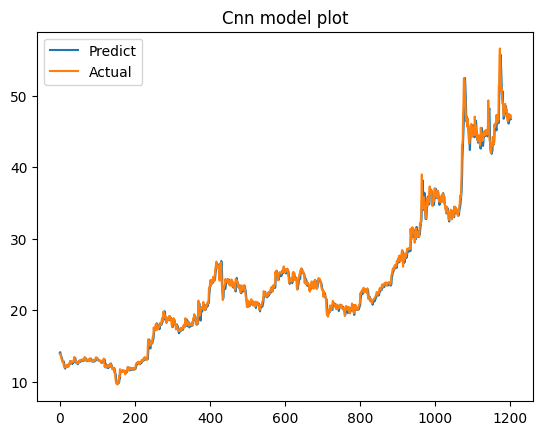

In [30]:
#評估
mae_exp, mse_exp, mape_exp, forecast_val = evaluated(cnn_model,X_val,y_val)
print(f"MAE:{mae_exp},MSE:{mse_exp},MAPE:{mape_exp}")
plot_predict(forecast_val,labels='Predict',title='Cnn model plot')

In [31]:
#RNN
rnn_model = Sequential()
rnn_model.add(SimpleRNN(60,return_sequences=True,input_shape=(window_size,1)))
rnn_model.add(SimpleRNN(50,return_sequences=True))
rnn_model.add(SimpleRNN(40))
rnn_model.add(Dense(40))
rnn_model.add(Dense(20))
rnn_model.add(Dense(1))
rnn_model.add(Lambda(lambda x: x * 400.0))
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 60)            3720      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 50)            5550      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3640      
                                                                 
 dense_8 (Dense)             (None, 40)                1640      
                                                                 
 dense_9 (Dense)             (None, 20)                820       
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
 lambda (Lambda)             (None, 1)                

In [32]:
#訓練
rnn_model.compile(loss='mse', optimizer='adam')
rnn_model.fit(train_data, epochs=350,verbose=0)

38/38 [==============================] - 1s 9ms/step
MAE:0.7100997567176819,MSE:0.728834331035614,MAPE:3.2417173385620117


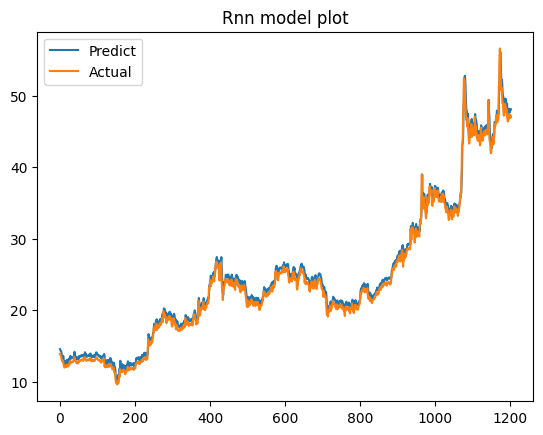

In [33]:
#評估
mae_exp, mse_exp, mape_exp, forecast_val = evaluated(rnn_model,X_val,y_val)
print(f"MAE:{mae_exp},MSE:{mse_exp},MAPE:{mape_exp}")
plot_predict(forecast_val,labels='Predict',title='Rnn model plot')

In [103]:
#LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(60,return_sequences=True,input_shape=(window_size,1)))
lstm_model.add(LSTM(50,return_sequences=True))
lstm_model.add(LSTM(40))
lstm_model.add(Dense(40))
lstm_model.add(Dense(20))
lstm_model.add(Dense(1))
lstm_model.add(Lambda(lambda x: x * 500.0))
lstm_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 20, 60)            14880     
                                                                 
 lstm_40 (LSTM)              (None, 20, 50)            22200     
                                                                 
 lstm_41 (LSTM)              (None, 40)                14560     
                                                                 
 dense_85 (Dense)            (None, 40)                1640      
                                                                 
 dense_86 (Dense)            (None, 20)                820       
                                                                 
 dense_87 (Dense)            (None, 1)                 21        
                                                                 
 lambda_19 (Lambda)          (None, 1)               

In [104]:
#訓練
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.fit(train_data, epochs=300,verbose=0)

7/7 [==============================] - 0s 2ms/step
MAE:2.676567792892456,MSE:12.837318420410156,MAPE:5.959995269775391


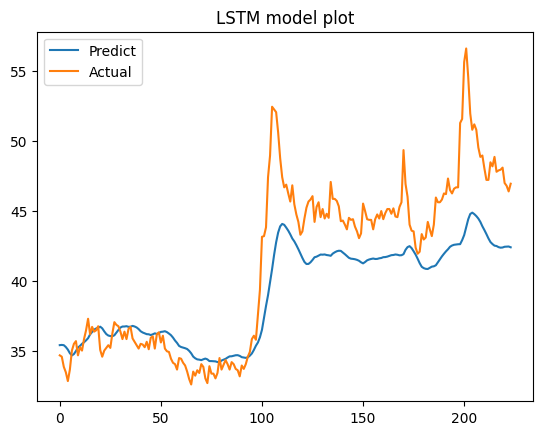

In [105]:
#評估
mae_exp, mse_exp, mape_exp, forecast_val = evaluated(lstm_model,X_val,y_val)
print(f"MAE:{mae_exp},MSE:{mse_exp},MAPE:{mape_exp}")
plot_predict(forecast_val,labels='Predict',title='LSTM model plot')

In [22]:
#Cnn+Rnn
crnn_model = Sequential()
crnn_model.add(Conv1D(filters=64, kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=(window_size, 1)))
crnn_model.add(MaxPooling1D(pool_size=2))
crnn_model.add(SimpleRNN(64,return_sequences=True))
crnn_model.add(SimpleRNN(32))
crnn_model.add(Dense(32))
crnn_model.add(Dense(16))
crnn_model.add(Dense(1))
crnn_model.add(Lambda(lambda x : x * 300.0))
crnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 simple_rnn (SimpleRNN)      (None, 10, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                      

In [24]:
#訓練
crnn_model.compile(loss='mse', optimizer='adam')
crnn_model.fit(train_data, epochs=250,verbose=0)

39/39 [==============================] - 0s 4ms/step
y_val:(1229,)
forecast_val:(1229,)
MAE:0.450253963470459,MSE:0.5159829258918762,MAPE:1.6185485124588013


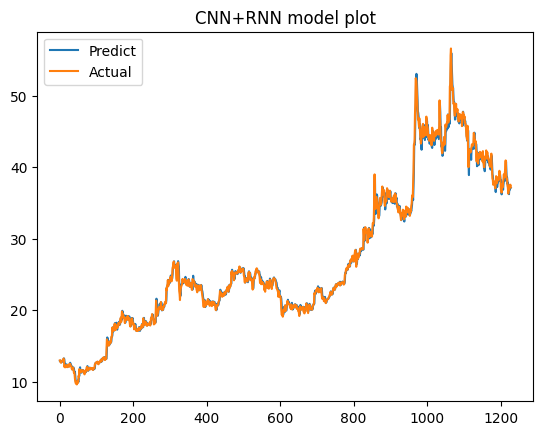

In [40]:
#評估
mae_exp, mse_exp, mape_exp, forecast_val = evaluated(crnn_model,X_val,y_val)
print(f"MAE:{mae_exp},MSE:{mse_exp},MAPE:{mape_exp}")
plot_predict(forecast_val,y_val,labels='Predict',title='CNN+RNN model plot')
#plot_predict(forecast_val,y_val,labels='Predict',title='CNN+RNN model plot',start_date="2023-05-05", end_date="2024-06-28")

In [42]:
#儲存模型
crnn_model.save('CNN_RNN_time_forecast_model')

INFO:tensorflow:Assets written to: CNN_RNN_time_forecast_model\assets


INFO:tensorflow:Assets written to: CNN_RNN_time_forecast_model\assets


In [56]:
##評估crnn_model模型預測趨勢準確率
#導入模型
crnn_model = tf.keras.models.load_model('CNN_RNN_time_forecast_model')

In [57]:
#抓取近1年數據
df_acer = yf.Ticker("2353.TW")
df_acer = df_acer.history(period="1y",interval="1d",)
data_1year = df_acer['Close'].values
data_1year = np.array(data_1year)
test_sample = data_1year[:20]
test_sample = test_sample.reshape((1, 20, 1))

In [58]:
#設定1星期預測值
for i in range(5):
    sample = test_sample[:,-20:,:]
    predicted = crnn_model.predict(sample)
    test_sample = np.append(test_sample,predicted)
    test_sample = test_sample.reshape((1, -1, 1))
    print(f"第{i+1}天預測完成")

1/1 [==============================] - 0s 106ms/step
第1天預測完成
1/1 [==============================] - 0s 13ms/step
第2天預測完成
1/1 [==============================] - 0s 12ms/step
第3天預測完成
1/1 [==============================] - 0s 12ms/step
第4天預測完成
1/1 [==============================] - 0s 12ms/step
第5天預測完成


In [59]:
#評估1星期預測值
forecast = test_sample[:,-5:,:].reshape(-1)
y = data_1year[20:25]
mae_exp = mean_absolute_error(y, forecast)
mse_exp = mean_squared_error(y, forecast)
mape_exp = mean_absolute_percentage_error(y, forecast)
print(f"MAE:{mae_exp},MSE:{mse_exp},MAPE:{mape_exp}")

MAE:0.8254768371582031,MSE:0.7331561710248934,MAPE:1.866469469668559


In [21]:
#TFT
#使用DARTS TFT
from darts.models import TFTModel
from darts import TimeSeries

In [34]:
#重設數據，ｔｆｔ不須以時間段區隔
data_tft = TimeSeries.from_series(data)
#切割train,test
train_tft , test_tft = data_tft[:split] , data_tft[split:]

In [35]:
#tft模型參數設置
tft_model = TFTModel(
    input_chunk_length=window_size,
    output_chunk_length=1,
    n_epochs=150,
    dropout=0.1,
    add_relative_index=True)

In [36]:
tft_model.fit(train_tft)

2024-07-07 15:17:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 4865 samples.
2024-07-07 15:17:33 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
C:\Users\tyhoo\Documents\python project\venv\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:585: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(
2024-07-07 15:17:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2024-07-07 15:17:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2024-07-07 15:17:33 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2024-07-07 15:17:33 pytorch_lightning.utilities.rank_zero INFO: HPU availabl

Training: 0it [00:00, ?it/s]

2024-07-07 15:33:59 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=150` reached.


In [37]:
test_tft = test_tft.values().flatten()
test_tft = TimeSeries.from_series(test_tft)

In [38]:
#進行預測
result_tft = tft_model.predict(series=test_tft,n=1202)

Predicting: 153it [00:00, ?it/s]

In [39]:
test_tft = test_tft.values().flatten()
result_tft= result_tft.values().flatten()

In [40]:
print(test_tft[20:].shape,result_tft.shape)

(1202,) (1202,)


In [41]:
#驗證
mae_exp = mean_absolute_error(test_tft[20:], result_tft)
mse_exp = mean_squared_error(test_tft[20:], result_tft)
mape_exp = mean_absolute_percentage_error(test_tft[20:], result_tft)
print(f"MAE:{mae_exp},MSE:{mse_exp},MAPE:{mape_exp}")

MAE:14.7382854654195,MSE:314.3477148557524,MAPE:54.92405747396914


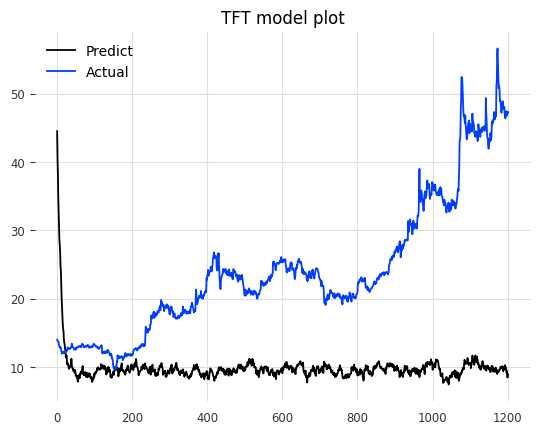

In [43]:
plot_predict(result_tft,labels='Predict',title='TFT model plot')